# Pierre's code Translation

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import time as tm
%matplotlib notebook

## Plot parameters

In [2]:
##Fontsize

SMALL_SIZE = 10
MEDIUM_SIZE = 16
LEGEND_SIZE = 12
BIGGER_SIZE = 22

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.direction'] = 'inout'
plt.rcParams['font.family'] = "serif"


## Functions 

In [3]:
def get_gf_fft_numerically(time, dist, vel, Q):
    """
    Compute the analytical GF between two points in a 2D homogeneous medium:
        time = time vector on which the GF will be interpolated: i.e. [0,1,100] [s]
        dist = distance between the two points [km]: i.e. 50
        vel = velocity of the medium [km/s]: i.e. 3 km/s
        Q = attenuation factor: i.e. 50
    """
    if dist != dist:
        dist = 0
    nt = time.size
    gf = np.zeros(nt)
    t0 = dist/vel
    rho = 1
    fe = 1./(time[1]-time[0])
    w1 = 2*np.pi*np.arange(0, fe/2, fe/nt)
    w2 = 2*np.pi*np.arange(-fe/2, -fe/nt, fe/nt)
    w = np.concatenate([w1, w2])
    gf1 = -1j/(4*rho*vel**2)
    gf2 = np.sqrt((2*vel/(np.pi*dist)))
    gf3 = np.exp(-1j*w*dist/vel)
    gf4 = np.exp(-w*dist/(2*vel*Q))
    gf5 = np.exp(1j*np.pi/4)
    gf = gf1*gf2*gf3*gf4*gf5
    m0 = int(np.ceil(gf.size/2))
    gf[m0::] = np.conjugate(gf[m0:1:-1])
    gf = np.real(np.fft.ifft(gf))
    return gf


## Initialize parameters

In [4]:
time = np.linspace(0, 40, 1001)
fs = time[2]
x = np.linspace(0, 20, 200)
y = np.linspace(0, 10, 100)
(X, Y) = np.meshgrid(x, y, indexing='ij')
GFS = np.zeros((len(time), X.shape[0], X.shape[1]))
GF1 = GFS
GF2 = GFS

### Bandpass filter

In [5]:
(b, a) = signal.butter(2, np.array([1, 3])*fs, 'bandpass')

## Source and Receivers position

In [6]:
x1 = 8
ix1 = np.argmin(abs(x-x1))
y1 = 5
iy1 = np.argmin(abs(y-y1))

x2 = 12
ix2 = np.argmin(abs(x-x2))
y2 = 5 
iy2 = np.argmin(abs(y-y2))

xS = 18
ixS = np.argmin(abs(x-xS))
yS = 7
iyS = np.argmin(abs(y-yS))

### Master GF

In [7]:

master_gf_1S = signal.lfilter(b, a, get_gf_fft_numerically(time, np.sqrt((xS-x1)**2+(yS-y1)**2), 1, 100))
master_gf_2S = signal.lfilter(b, a, get_gf_fft_numerically(time, np.sqrt((xS-x2)**2+(yS-y2)**2), 1, 100))
master_gf_12 = signal.lfilter(b, a, get_gf_fft_numerically(time, np.sqrt((x1-x2)**2+(y1-y2)**2), 1, 100))

for ix in range(len(x)):
    for iy in range(len(y)):
        dS = np.sqrt((x[ix]-xS)**2+(y[iy]-yS)**2)
        d1 = np.sqrt((x[ix]-x1)**2+(y[iy]-y1)**2)
        d2 = np.sqrt((x[ix]-x2)**2+(y[iy]-y2)**2)
        GFS[:, ix, iy] = signal.lfilter(b, a, get_gf_fft_numerically(time, dS, 1, 100))
        GF1[:, ix, iy] = signal.lfilter(b, a, get_gf_fft_numerically(time, d1, 1, 100))
        GF2[:, ix, iy] = signal.lfilter(b, a, get_gf_fft_numerically(time, d2, 1, 100))

<IPython.core.display.Javascript object>


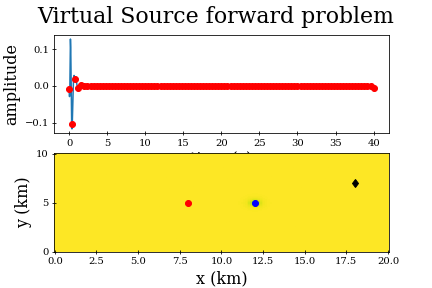

In [10]:
fig, ax = plt.subplots(2, 1)
ax1 = ax[0]
ax1.plot(time, GF1[:, ix2, iy2])
ax1.set_xlabel('time (s)')
ax1.set_ylabel('amplitude')

ax2 = ax[1]
ax2.plot(x1, y1, 'ro')
ax2.plot(x2, y2, 'bo')
ax2.plot(xS, yS, 'kd')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')
fig.suptitle('Virtual Source forward problem')
for it in np.arange(0, len(GFS), 10):
    ax1.plot(time[it], GF1[it, ix2, iy2], 'ro')
    ax2.pcolormesh(X, Y, GF1[it,:,:])
    fig.canvas.draw()
    tm.sleep(0.1)
plt.close('all')

In [11]:
C = np.zeros((2*len(time)-1, X.shape[0], X.shape[1]))

for ix in range(len(x)):
    for iy in range(len(y)):
        C[:, ix, iy] = signal.fftconvolve(GF1[:, ix, iy], GF2[:, ix, iy], mode='full')

<IPython.core.display.Javascript object>


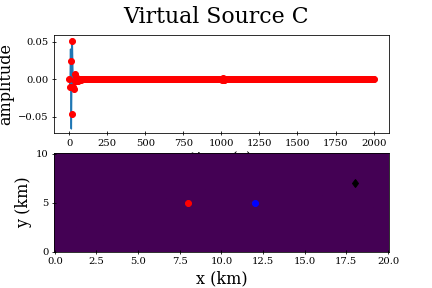

In [12]:
fig, ax = plt.subplots(2, 1)
ax1 = ax[0]
ax1.plot(C[:, ix2, iy2])
ax1.set_xlabel('time (s)')
ax1.set_ylabel('amplitude')
ax2 = ax[1]
ax2.plot(x1, y1, 'ro')
ax2.plot(x2, y2, 'bo')
ax2.plot(xS, yS, 'kd')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')
fig.suptitle('Virtual Source C')
for it in np.arange(0, C.shape[0], 5):
    ax1.plot(it, C[it, ix2, iy2], 'ro')
    ax2.pcolormesh(X, Y, C[it,:,:])
    fig.canvas.draw()
    tm.sleep(0.01)
plt.close('all')

In [14]:
CC = np.zeros((3*len(time)-2, X.shape[0], X.shape[1]))
CO = np.zeros((3*len(time)-2, X.shape[0], X.shape[1]))

for ix in range(len(x)):
    for iy in range(len(y)):
        CO[:, ix, iy] = signal.fftconvolve(GF1[:, ix, iy], signal.fftconvolve(GFS[:, ix, iy], master_gf_2S[::-1], "full"), "full") + signal.fftconvolve(GF2[:, ix, iy], signal.fftconvolve(GFS[:, ix, iy], master_gf_1S[::-1], "full"), "full")
        CC[:, ix, iy] = signal.fftconvolve(GF1[:, ix, iy][::-1], signal.fftconvolve(GFS[:, ix, iy], master_gf_2S[::-1], "full"), "full") + signal.fftconvolve(GF2[:, ix, iy][::-1], signal.fftconvolve(GFS[:, ix, iy], master_gf_1S[::-1], "full"), "full")


xx = ix1
yy = iy1

<IPython.core.display.Javascript object>


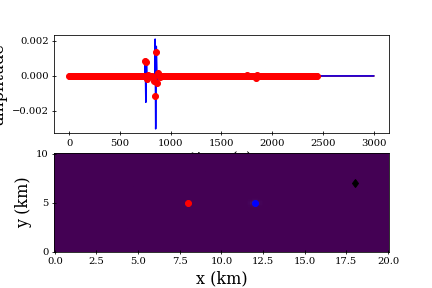

In [ ]:
fig, ax = plt.subplots(2, 1)
ax1 = ax[0]
ax1.plot(CO[:, ixS, iyS], 'k')
ax1.plot(CO[:, ix1, iy1], 'r')
ax1.plot(CO[:, ix2, iy2], 'b')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('amplitude')

ax2 = ax[1]
ax2.plot(x1, y1, 'ro')
ax2.plot(x2, y2, 'bo')
ax2.plot(xS, yS, 'kd')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')
for it in np.arange(0, len(CO), 10):
    ax1.plot(it, CO[it, ix2, iy2], 'ro')
    
    ax2.pcolormesh(X, Y, CO[it,:,:])
    fig.canvas.draw()
    tm.sleep(0.01)

In [ ]:
fig, ax = plt.subplots(2, 1)
ax1 = ax[0]
ax1.plot(CC[:, ixS, iyS], 'k')
ax1.plot(CC[:, ix1, iy1], 'r')
ax1.plot(CC[:, ix2, iy2], 'b')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('amplitude')
ax2.plot(x1, y1, 'ro')
ax2.plot(x2, y2, 'bo')
ax2.plot(xS, yS, 'kd')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')
ax2 = ax[1]
for it in np.arange(0, len(CC), 10):
    ax1.plot(it, CC[it, ix2, iy2], 'ro')
    ax2.pcolormesh(X, Y, CC[it,:,:])
    fig.canvas.draw()
    tm.sleep(0.01)

In [ ]:
it = np.argmax(abs(CO[:, xx, yy]))
fig, ax = plt.subplots(2,2)
ax1 = ax[0, 0]
ax1.plot(CO[:, xx, yy])
ax1.plot(it, CO[it, xx, yy], 'ro')

ax2 = ax[1, 0]
ax2.pcolormesh(X, Y, CO[it, :, :])
ax2.plot(x1, y1, 'ro')
ax2.plot(x2, y2, 'bo')
ax2.plot(xS, yS, 'kd')

it = np.argmax(abs(CC[:, xx, yy]))
ax3 = ax[0, 1]
ax3.plot(CC[:, xx, yy])
ax3.plot(it, CC[it, xx, yy], 'ro')

ax4 = ax[1, 1]
ax4.pcolormesh(X, Y, CC[it, :, :])
ax4.plot(x1, y1, 'ro')
ax4.plot(x2, y2, 'bo')
ax4.plot(xS, yS, 'kd')
plt.show()